# What will be the best location to pick-up customers for each day of the week of a month?


## Preamble

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from geopy.geocoders import Nominatim

## Load the data

In [2]:
df=pd.read_csv("datasets/yellow_tripdata_2013-01.csv")

## Preprocess data

In [3]:
#create new column call weekday
timestamp = pd.to_datetime(pd.Series(df['pickup_datetime']))
df['weekday'] = timestamp.dt.weekday_name
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,weekday
0,CMT,2013-01-01 15:11:48,2013-01-01 15:18:10,4,1.0,-73.978165,40.757977,1,N,-73.989840,40.751173,CSH,6.5,0.0,0.5,0.0,0.0,7.0,Tuesday
1,CMT,2013-01-06 00:18:35,2013-01-06 00:22:54,1,1.5,-74.006680,40.731781,1,N,-73.994499,40.750659,CSH,6.0,0.5,0.5,0.0,0.0,7.0,Sunday
2,CMT,2013-01-05 18:49:41,2013-01-05 18:54:23,1,1.1,-74.004711,40.737770,1,N,-74.009831,40.726000,CSH,5.5,1.0,0.5,0.0,0.0,7.0,Saturday
3,CMT,2013-01-07 23:54:15,2013-01-07 23:58:20,2,0.7,-73.974600,40.759945,1,N,-73.984737,40.759388,CSH,5.0,0.5,0.5,0.0,0.0,6.0,Monday
4,CMT,2013-01-07 23:25:03,2013-01-07 23:34:24,1,2.1,-73.976252,40.748528,1,N,-74.002583,40.747867,CSH,9.5,0.5,0.5,0.0,0.0,10.5,Monday


In [4]:
#drop unnecessary column
df = df.drop(['vendor_id','passenger_count','trip_distance','rate_code',
              'store_and_fwd_flag','payment_type','fare_amount','surcharge','mta_tax',
             'tip_amount','tolls_amount','total_amount','dropoff_datetime',
              'dropoff_longitude','dropoff_latitude'], axis=1)

#get rid off some garbage data
df=df[(df['pickup_latitude'] > 40.492083) & (df['pickup_latitude']<40.944536) &
     (df['pickup_longitude']> -74.267880)& (df['pickup_longitude']< -73.662022)]

df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,weekday
0,2013-01-01 15:11:48,-73.978165,40.757977,Tuesday
1,2013-01-06 00:18:35,-74.006680,40.731781,Sunday
2,2013-01-05 18:49:41,-74.004711,40.737770,Saturday
3,2013-01-07 23:54:15,-73.974600,40.759945,Monday
4,2013-01-07 23:25:03,-73.976252,40.748528,Monday


## Helper Functions

In [5]:
#regression function for calculating score
def fit_model(X, y):
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X, y)
    return model

def score_model(model, X, y, Xv, yv):
    return tuple([model.score(X, y), model.score(Xv, yv)])

def fit_model_and_score(data, response, validation, val_response):
    model = fit_model(data, response)
    return score_model(model, data, response, validation, val_response)


In [6]:
#convert to address
def convert_to_address(coordinate):
    geolocator = Nominatim()
    location = geolocator.reverse(coordinate)
    return location.address

## Main Function

In [7]:
#get best location for each weekday in a month
def poly_regression(my_month,my_weekday,df):
    #get all the selected weekdays in selected month
    df_select=df[(df['weekday']==my_weekday) & 
                 (pd.to_datetime(df['pickup_datetime']) < pd.datetime(2013,my_month+1,1))&
                (pd.to_datetime(df['pickup_datetime']) > pd.datetime(2013,my_month,1))]
    
    df_select=df_select[:70000]
    #use Kmean to group data by longitude and latitude
    my_cluster=100
    lon=df_select['pickup_longitude'].values
    lat=df_select['pickup_latitude'].values
    coodinate_array=np.array([[lon[i],lat[i]] for i in range(len(lon))])

    kmeans_n = KMeans(n_clusters=my_cluster,n_init=1,random_state=1000)
    kmeans_n.fit(coodinate_array)
    labels = kmeans_n.labels_
    
    # add new column call cluster
    df_select['Cluster']=labels
    
    #prepare for regression
    Cluster_size=df_select.groupby('Cluster').size()
    Cluster_size=np.array([[Cluster_size[i]] for i in range(len(Cluster_size))])
    Cluster_center=kmeans_n.cluster_centers_
    
    #get training data and testing data
    train_size=int(len(Cluster_size)*0.8)
    test_size=int(len(Cluster_size)*0.2)
    train_feature=Cluster_size[:train_size]
    train_response=Cluster_center[:train_size]
    test_feature=Cluster_size[test_size:]
    test_response=Cluster_center[test_size:]
    
    #coefficient of determination (R^2)
    print ("coefficient of determination (R^2):",fit_model_and_score(train_feature, train_response,
                           test_feature, test_response))
    
    #use mean squared error to evaluation model
    MSE_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
    MSE_model.fit(train_feature, train_response)
    X_MSE=(test_feature)
    y_MSE = MSE_model.predict(X_MSE)
    print("MSE: ",mean_squared_error(test_response, y_MSE))
    
    #predict best location
    X=Cluster_size
    y=Cluster_center

    prediction_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                    ('linear', LinearRegression(fit_intercept=False))])
    prediction_model.fit(X, y)
    X_predict=([max(Cluster_size)])
    y_predict = prediction_model.predict(X_predict)
    print("best location for ",my_weekday, y_predict)
    
    #prepare for visualization
    for data in y_predict:
        visual_x=data[[0]]
        visual_y=data[[1]]
        
    #convert to address
    print("address: ",convert_to_address(str(visual_y[0])+","+str(visual_x[0])))
        
    #scatter plot all the data for selected weekday and prediction(best location in red)
    x_points=lon
    y_points=lat
    plt.figure(figsize=(18,9))
    plt.scatter(lon,lat,alpha=0.2,s=100)
    plt.scatter(visual_x,visual_y ,c='r',s=100)
    plt.axis([visual_x-0.05,visual_x+0.05,visual_y-0.05,visual_y+0.05])
    plt.title("Best pick up location (red point)")
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.show()

## Execution

coefficient of determination (R^2): (0.024009499824791475, 0.035774574862068031)
MSE:  0.00374626826592
best location for  Monday [[-73.98130718  40.76049577]]
address:  Time-Life Building, 1271, 6th Avenue, Diamond District, Manhattan, New York County, NYC, New York, 10019, United States of America


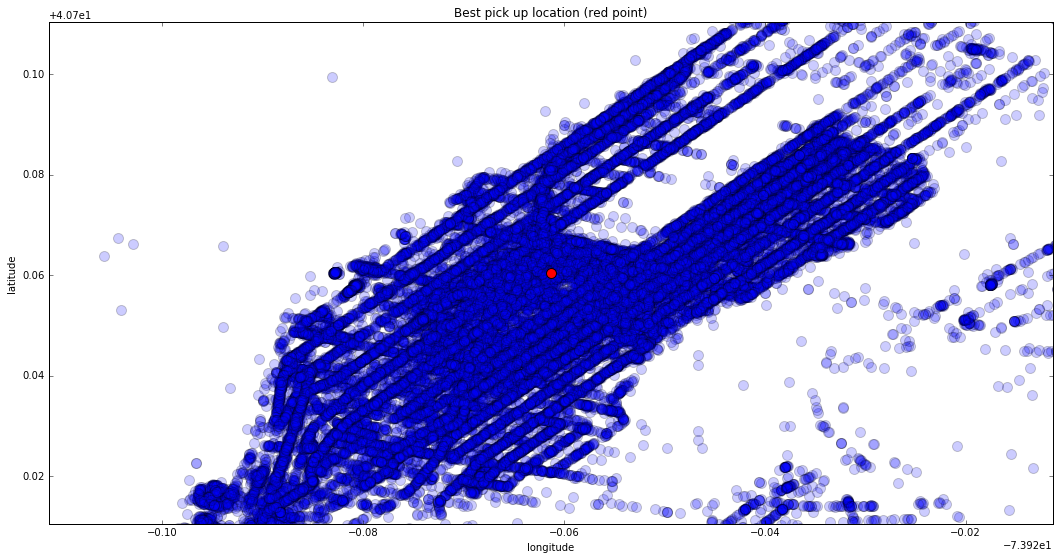

coefficient of determination (R^2): (0.06518329759293294, 0.049350242975739547)
MSE:  0.00455823095376
best location for  Tuesday [[-73.9716803   40.76258281]]
address:  605, Madison Avenue, Diamond District, Manhattan, New York County, NYC, New York, 10022, United States of America


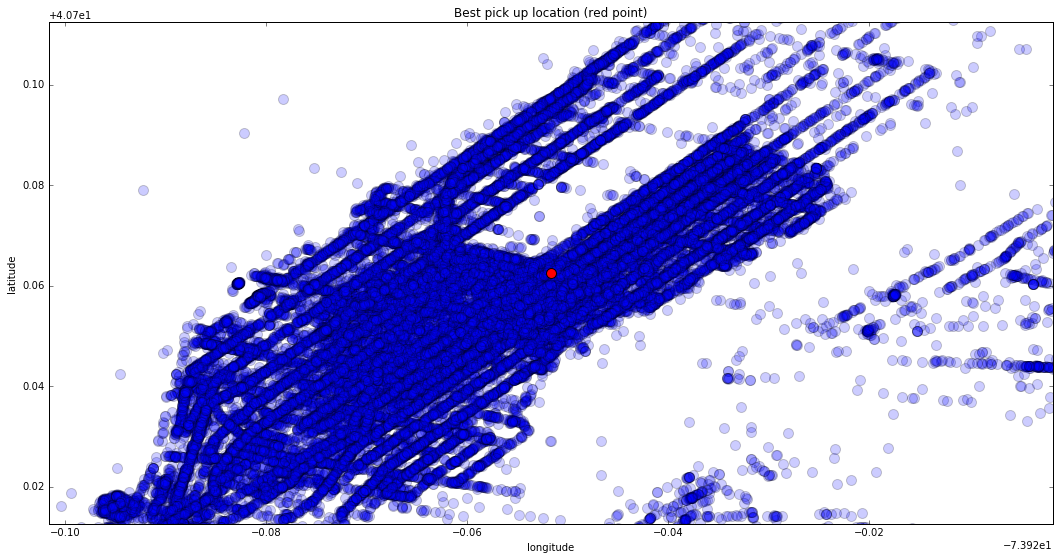

coefficient of determination (R^2): (0.059283565848756631, 0.064747055462713587)
MSE:  0.00345474444929
best location for  Wednesday [[-73.97949472  40.74582178]]
address:  Affinia Dumont, 150, East 34th Street, Murray Hill, Manhattan, New York County, NYC, New York, 10016, United States of America


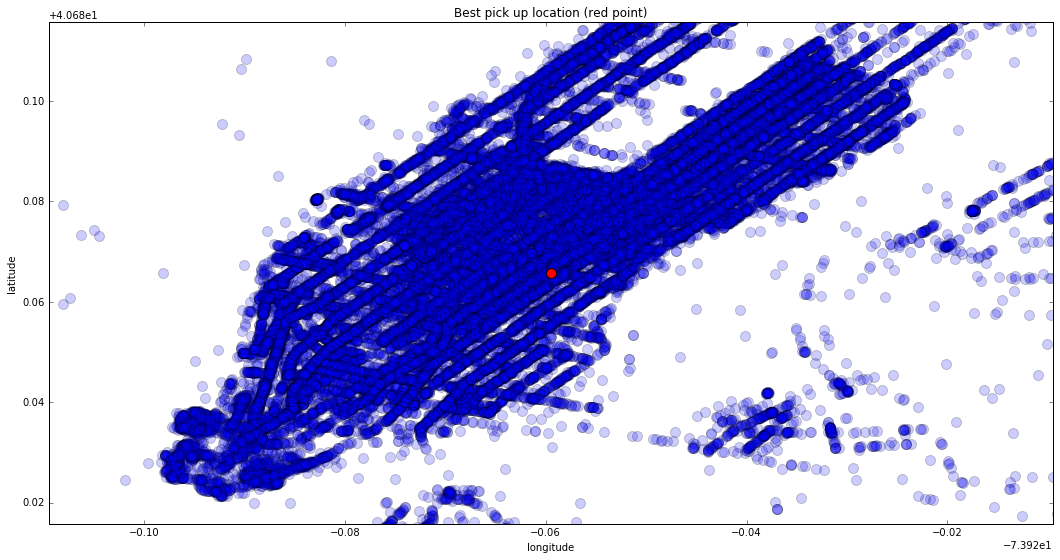

coefficient of determination (R^2): (0.027825963041113948, 0.02908223456433277)
MSE:  0.00473285314805
best location for  Thursday [[-73.9752935   40.76064827]]
address:  681, 5th Avenue, Diamond District, Manhattan, New York County, NYC, New York, 10022, United States of America


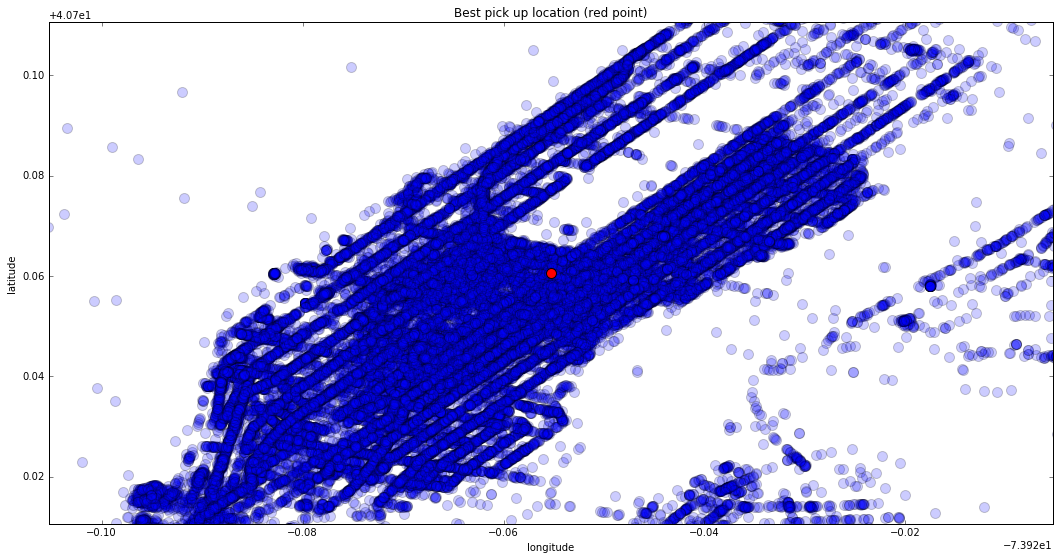

coefficient of determination (R^2): (0.081413101194937054, 0.068641130093586591)
MSE:  0.00438072476595
best location for  Friday [[-73.98971647  40.761148  ]]
address:  344, West 47th Street, Hell's Kitchen, Manhattan, New York County, NYC, New York, 10036, United States of America


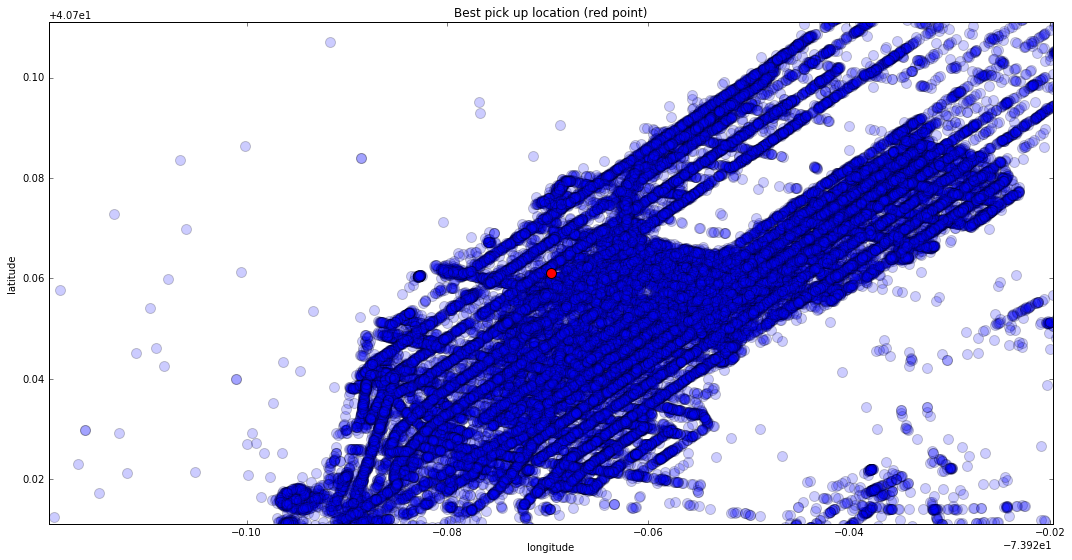

coefficient of determination (R^2): (0.037857749442918372, 0.0027166421184214797)
MSE:  0.00345039874901
best location for  Saturday [[-73.98551247  40.72353486]]
address:  39, Avenue A, Alphabet City, Manhattan, New York County, NYC, New York, 10009, United States of America


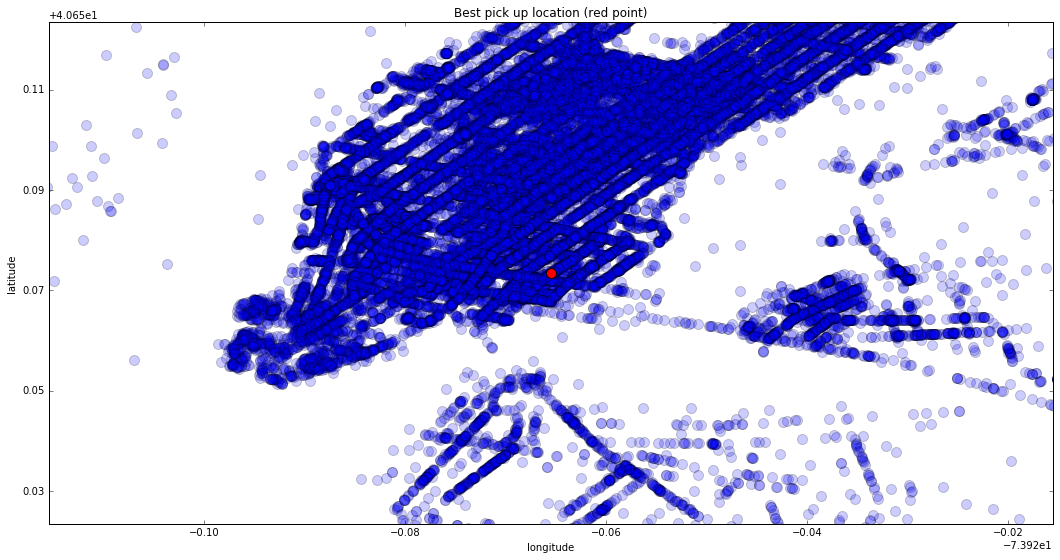

coefficient of determination (R^2): (0.05374451422887748, 0.051264427712212068)
MSE:  0.00310477982167
best location for  Sunday [[-73.98711418  40.7511347 ]]
address:  Herald Square Building, West 36th Street, Koreatown, Manhattan, New York County, NYC, New York, 10018, United States of America


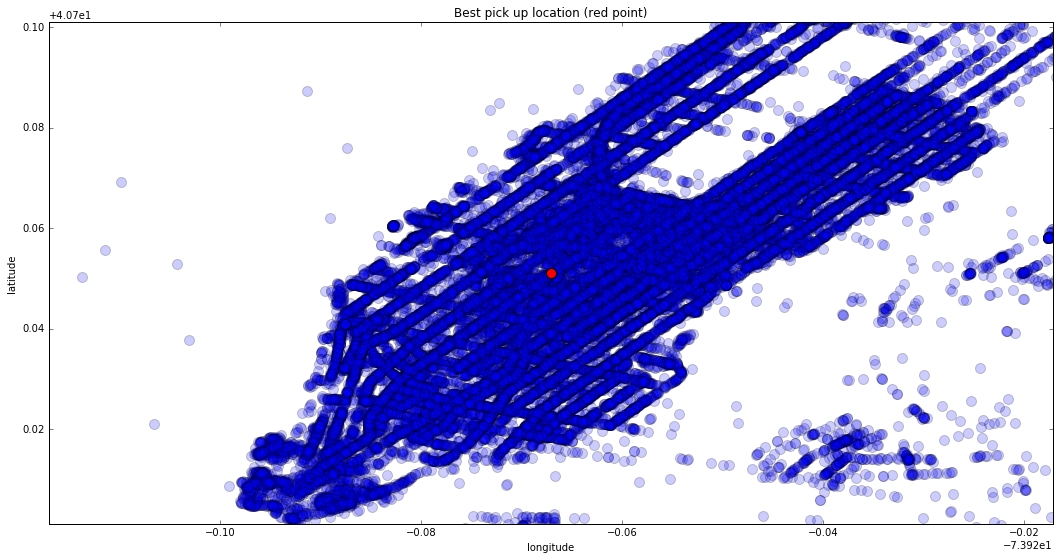

In [8]:
dayweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

for day in dayweek:
    poly_regression(1,day,df)
